In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statistics import stdev
import statsmodels
from statsmodels.sandbox.stats.multicomp import multipletests
import imblearn
import sys
from numpy import mean, absolute, sqrt
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors
import sklearn.preprocessing
from xgboost import XGBClassifier
import sklearn.ensemble
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from itertools import combinations, cycle
import time

In [2]:
df = pd.read_csv('/Users/katherine/Desktop/BrainPower/data/final_dataset/data_with_biomarkers.csv', sep='\t')
df.fillna(df.min(), inplace=True)
columns_to_drop = ["assay_ID", "Ttau (pg/ml)", "AB42/AB40"]
df.drop(columns_to_drop, axis=1, inplace=True)

In [3]:
df_AD_MCI = df[df["group"].isin(["AD_MCI"])]
df_healthy = df[df["group"].isin(["Healthy"])]
df_PD = df[df["group"].isin(["PD"])]
df_PD_MCI_LBD = df[df["group"].isin(["PD_MCI_LBD"])]

In [4]:
df_AD_MCI.set_index('group', inplace=True)
df_healthy.set_index('group', inplace=True)
df_PD.set_index('group', inplace=True)
df_PD_MCI_LBD.set_index('group', inplace=True)

In [5]:
# Confirm the headers of all the dataframes are the samelbist(df_AD_MCI.columns) == list(df_healthy.columns) == list(df_PD.columns) == list(df_PD_MCI_LBD.columns)

In [6]:
list_columns = list(df_AD_MCI.columns)

In [7]:
def reversed_delimited_tuple(string,delimiter='|'):
    delimited_tuple = string.split(delimiter)
    reversed_tuple = delimited_tuple[::-1]
    return reversed_tuple

In [8]:
# List proteins by last short-name identifier used in column title
list_proteins = []
for protein_string in list_columns:
    list_proteins.append(reversed_delimited_tuple(protein_string)[0])

In [9]:
# Create dictionary of extended protein info : short identifier
dict_proteins = {}
for i in range(0,len(list_proteins)):
    dict_proteins[list_columns[i]] = list_proteins[i]

In [10]:
df_AD_MCI = df_AD_MCI.rename(columns=dict_proteins)
df_healthy = df_healthy.rename(columns=dict_proteins)
df_PD = df_PD.rename(columns=dict_proteins)
df_PD_MCI_LBD = df_PD_MCI_LBD.rename(columns=dict_proteins)

In [11]:
def gen_volcano_tuple(test_frame,control_frame):
    # Returns ['protein','avg_expr_cond','avg_expr_healthy','log2_FC','t_value','log10_p_value']
    datalist = []
    
    for protein in list_proteins:
        t_stat, p_stat = scipy.stats.ttest_ind(test_frame[protein],control_frame[protein],equal_var=False)
        datalist.append([protein,test_frame[protein].mean(), control_frame[protein].mean(),
                        np.log2(test_frame[protein].mean()/control_frame[protein].mean()),
                        float(t_stat), float(np.log10(p_stat))*-1])

    return datalist

In [12]:
AD_MCI_volcano_datalist = gen_volcano_tuple(df_AD_MCI,df_healthy)
PD_volcano_datalist = gen_volcano_tuple(df_PD,df_healthy)
PD_MCI_LBD_volcano_datalist = gen_volcano_tuple(df_PD_MCI_LBD,df_healthy)
PD_vs_MCI_volcano_datalist = gen_volcano_tuple(df_PD_MCI_LBD,df_PD)

In [13]:
df_volcano_AD_MCI = pd.DataFrame(data=AD_MCI_volcano_datalist, columns=['protein','avg_expr_cond','avg_expr_healthy','log2_FC','t_value','log10_p_value'])
df_volcano_PD = pd.DataFrame(data=PD_volcano_datalist, columns=['protein','avg_expr_cond','avg_expr_healthy','log2_FC','t_value','log10_p_value'])
df_volcano_PD_MCI = pd.DataFrame(data=PD_MCI_LBD_volcano_datalist, columns=['protein','avg_expr_cond','avg_expr_healthy','log2_FC','t_value','log10_p_value'])
df_volcano_PD_vs_PD_MCI = pd.DataFrame(data=PD_vs_MCI_volcano_datalist, columns=['protein','avg_expr_cond','avg_expr_healthy','log2_FC','t_value','log10_p_value'])

In [14]:
features = ['TAU', 'GLCM', 'LY86', 'HLAA', 'SPRN', 'KCC2D', '1433B', 'NPTX2', 'NEUG', 'COLA1', 'ANXA2', 'ITM2B', '1433G', 'PGM1', 'PTPRT', 'LV545', 'AMPN']

features_AD = df_volcano_AD_MCI[df_volcano_AD_MCI['protein'].isin(features)]
features_PD = df_volcano_PD[df_volcano_PD['protein'].isin(features)]
features_PD_MCI = df_volcano_PD_MCI[df_volcano_PD_MCI['protein'].isin(features)]
features_PD_vs_PD_MCI = df_volcano_PD_vs_PD_MCI[df_volcano_PD_vs_PD_MCI['protein'].isin(features)]

In [15]:
def feature_list(features):
    AD_protein = np.array(features['protein'])
    AD_log2_FC = np.array(features['log2_FC'])
    AD_log10_p_values = np.array(features['log10_p_value'])
    
    feature_list = pd.DataFrame({
        'log2_FC': AD_log2_FC,
        'log10_p_value': AD_log10_p_values,
        'protein': AD_protein
    })
    return feature_list

In [16]:
features_AD = feature_list(features_AD)
features_PD = feature_list(features_PD)
features_PD_MCI = feature_list(features_PD_MCI)
features_PD_vs_PD_MCI = feature_list(features_PD_vs_PD_MCI)

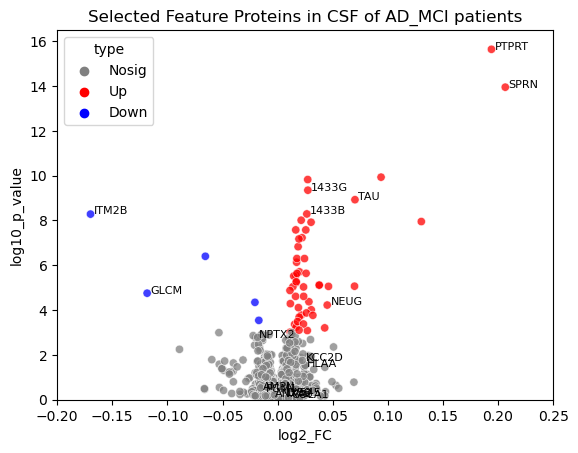

In [17]:
df_volcano_AD_MCI.loc[(df_volcano_AD_MCI.log2_FC>0)&(df_volcano_AD_MCI.log10_p_value>3),'type']='Up'
df_volcano_AD_MCI.loc[(df_volcano_AD_MCI.log2_FC<0)&(df_volcano_AD_MCI.log10_p_value>3),'type']='Down'
df_volcano_AD_MCI.loc[(df_volcano_AD_MCI.log10_p_value<=3),'type']='Nosig'

colors = ["grey","red","blue"]

ax=sns.scatterplot(x='log2_FC', y='log10_p_value',data=df_volcano_AD_MCI, hue='type', palette=colors, alpha=0.75)

ax.set_title("Selected Feature Proteins in CSF of AD_MCI patients")
ax.set_xlabel("log2_FC")
ax.set_ylabel("log10_p_value")

for i in range(features_AD.shape[0]):
    ax.text(x=features_AD.log2_FC[i]+0.003,y=features_AD.log10_p_value[i],s=features_AD.protein[i], size=8)

plt.xlim(-0.2, 0.25)
plt.ylim(0, 16.5)

plt.savefig('AD', bbox_inches='tight')

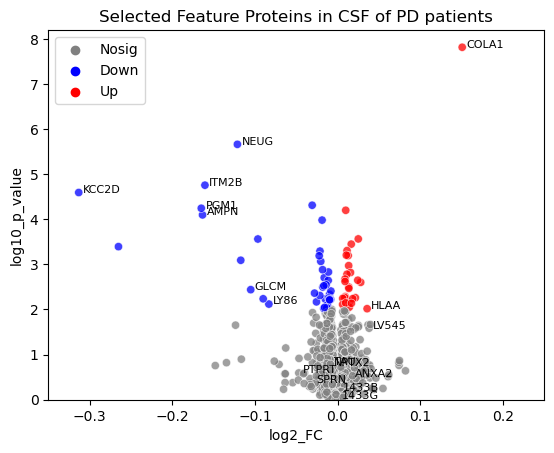

In [18]:
df_volcano_PD.loc[(df_volcano_PD.log2_FC>0)&(df_volcano_PD.log10_p_value>2),'type']='Up'
df_volcano_PD.loc[(df_volcano_PD.log2_FC<0)&(df_volcano_PD.log10_p_value>2),'type']='Down'
df_volcano_PD.loc[(df_volcano_PD.log10_p_value<=2),'type']='Nosig'

colors = ["grey","blue","red"]

ax=sns.scatterplot(x='log2_FC', y='log10_p_value',data=df_volcano_PD, hue='type', palette=colors, alpha=0.75)

ax.set_title("Selected Feature Proteins in CSF of PD patients")
ax.set_xlabel("log2_FC")
ax.set_ylabel("log10_p_value")

for i in range(features_PD.shape[0]):
    ax.text(x=features_PD.log2_FC[i]+0.005,y=features_PD.log10_p_value[i],s=features_PD.protein[i], size=8)

plt.xlim(-0.35, 0.25)
plt.ylim(0, 8.2)
plt.legend(loc='upper left')

plt.savefig('PD', bbox_inches='tight')

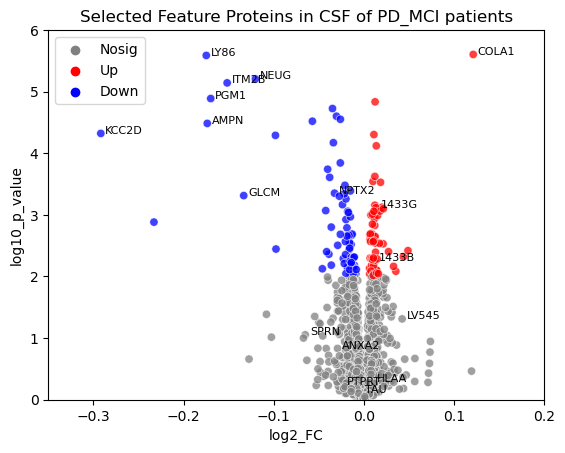

In [19]:
df_volcano_PD_MCI.loc[(df_volcano_PD_MCI.log2_FC>0)&(df_volcano_PD_MCI.log10_p_value>2),'type']='Up'
df_volcano_PD_MCI.loc[(df_volcano_PD_MCI.log2_FC<0)&(df_volcano_PD_MCI.log10_p_value>2),'type']='Down'
df_volcano_PD_MCI.loc[(df_volcano_PD_MCI.log10_p_value<=2),'type']='Nosig'

colors = ["grey","red","blue"]

ax=sns.scatterplot(x='log2_FC', y='log10_p_value',data=df_volcano_PD_MCI, hue='type', palette=colors, alpha=0.75)

ax.set_title("Selected Feature Proteins in CSF of PD_MCI patients")
ax.set_xlabel("log2_FC")
ax.set_ylabel("log10_p_value")


for i in range(features_PD_MCI.shape[0]):
    ax.text(x=features_PD_MCI.log2_FC[i]+0.005,y=features_PD_MCI.log10_p_value[i],s=features_PD_MCI.protein[i], size=8)
    , bbox_inches='tight')

plt.xlim(-0.35, 0.2)
plt.ylim(0, 6)
plt.legend(loc='upper left')

plt.savefig('PD_MCI', bbox_inches='tight')

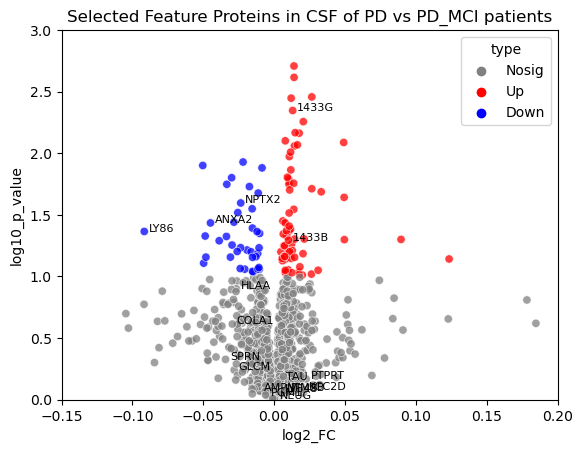

In [20]:
df_volcano_PD_vs_PD_MCI.loc[(df_volcano_PD_vs_PD_MCI.log2_FC>0)&(df_volcano_PD_vs_PD_MCI.log10_p_value>1),'type']='Up'
df_volcano_PD_vs_PD_MCI.loc[(df_volcano_PD_vs_PD_MCI.log2_FC<0)&(df_volcano_PD_vs_PD_MCI.log10_p_value>1),'type']='Down'
df_volcano_PD_vs_PD_MCI.loc[(df_volcano_PD_vs_PD_MCI.log10_p_value<=1),'type']='Nosig'

colors = ["grey","red","blue"]

ax=sns.scatterplot(x='log2_FC', y='log10_p_value',data=df_volcano_PD_vs_PD_MCI, hue='type', palette=colors, alpha=0.75)

ax.set_title("Selected Feature Proteins in CSF of PD vs PD_MCI patients")
ax.set_xlabel("log2_FC")
ax.set_ylabel("log10_p_value")

for i in range(features_PD_vs_PD_MCI.shape[0]):
    ax.text(x=features_PD_vs_PD_MCI.log2_FC[i]+0.003,y=features_PD_vs_PD_MCI.log10_p_value[i],s=features_PD_vs_PD_MCI.protein[i], size=8)

plt.xlim(-0.15, 0.2)
plt.ylim(0, 3)

plt.savefig('PD_vs_PD_MCI', bbox_inches='tight')

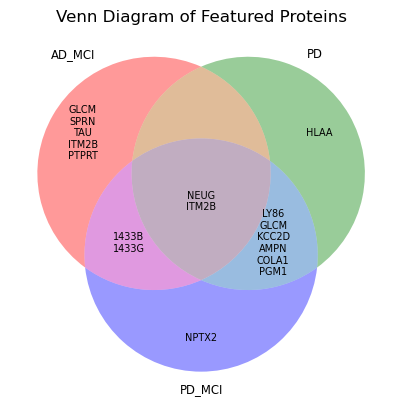

In [21]:
### import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
AD = set(['TAU', 'PTPRT', 'SPRN', 'ITM2B', 'GLCM'])
PD = set(['HLAA'])
PD_MCI = set(['NPTX2'])
AD_PD = set([])
AD_PD_MCI = set(['1433B', '1433G'])
PD_PD_MCI = set(['COLA1', 'LY86', 'PGM1', 'AMPN', 'KCC2D', 'GLCM'])
AD_PD_PD_MCI = set(['NEUG', 'ITM2B'])

font1 = {'family':'DejaVu Sans', 'size':12} # use for title
font2 = {'family': 'DejaVu Sans', 'size': 7} # use for labels
plt.rc('font', **font2) # sets the default font 

# Create an empty Venn diagram with three circles
venn = venn3(subsets=(3, 3, 3, 3, 3, 3, 3), set_labels=('A', 'B', 'C'))

# Add circle labels
venn.get_label_by_id('A').set_text('AD_MCI')
venn.get_label_by_id('B').set_text('PD')
venn.get_label_by_id('C').set_text('PD_MCI')

# Add title
plt.title('Venn Diagram of Featured Proteins', fontdict=font1)

venn.get_label_by_id('100').set_text('\n'.join(AD))
venn.get_label_by_id('010').set_text('\n'.join(PD))
venn.get_label_by_id('001').set_text('\n'.join(PD_MCI))
venn.get_label_by_id('110').set_text('\n'.join(AD_PD))
venn.get_label_by_id('101').set_text('\n'.join(AD_PD_MCI))
venn.get_label_by_id('011').set_text('\n'.join(PD_PD_MCI))
venn.get_label_by_id('111').set_text('\n'.join(AD_PD_PD_MCI))

# Display diagram
plt.savefig('venn_diagram.png', bbox_inches='tight')
plt.show()